In [174]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from gplearn.genetic import SymbolicRegressor, SymbolicTransformer
import matplotlib.pyplot as plt

In [175]:
df = pd.read_csv("car_sales_data.csv")

In [176]:
print("First five rows: \n")
df.head()

First five rows: 



,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


In [177]:
print("Data informations: \n")
df.info()

Data informations: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


In [178]:
print("Data descriptions: \n")
df.describe()

Data descriptions: 



,Engine size,Year of manufacture,Mileage,Price
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.773058,2004.209440,112497.320700,13828.903160
std,0.734108,9.645965,71632.515602,16416.681336
min,1.000000,1984.000000,630.000000,76.000000
25%,1.400000,1996.000000,54352.250000,3060.750000
50%,1.600000,2004.000000,100987.500000,7971.500000
75%,2.000000,2012.000000,158601.000000,19026.500000
max,5.000000,2022.000000,453537.000000,168081.000000


In [179]:
df_encoded = pd.get_dummies(df, columns=["Fuel type", "Manufacturer", "Model"], drop_first=True)

X = df_encoded.drop(columns=["Price"])
y = df_encoded["Price"]

X[["Year of manufacture"]] = 2025 - X[["Year of manufacture"]]
X = X.rename(columns={'Year of manufacture': 'Age of car'})

X[["Engine size", "Mileage", "Age of car"]] = (
            (X[["Engine size", "Mileage", "Age of car"]] - X[["Engine size", "Mileage", "Age of car"]].mean()) /
            X[["Engine size", "Mileage", "Age of car"]].std())
y = (y - y.mean()) / y.std()

In [180]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
transformer = SymbolicTransformer(generations=20,
                                  population_size=5000,
                                  hall_of_fame=100,
                                  n_components=10,
                                  function_set=function_set,
                                  parsimony_coefficient=0.0001,
                                  max_samples=0.9,
                                  verbose=1,
                                  random_state=42,
                                  n_jobs=3)

transformer.fit_transform(X, y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.58         0.100597       12         0.782857         0.784215      2.54m
   1     9.75         0.383547       17         0.860535         0.853558      1.69m
   2     6.87         0.582001       19         0.931751         0.932663      1.48m
   3     9.89         0.620116       16         0.943368         0.936988      5.13m
   4    16.03         0.704036       30         0.951609         0.953954      5.97m
   5    21.61         0.778151       31         0.956864         0.958738      2.31m
   6    26.01         0.801948       34         0.959324          0.96018      1.50m
   7    26.81         0.796003       36         0.966473         0.965681      5.04m
   8    32.35         0.846549       54           0.9725         0.975246  

array([[-0.22905329, -0.22905329, -0.22905329, ..., -0.22905329,
        -0.22905329, -0.22905329],
       [21.56817987, 21.56817987, 16.36610357, ..., 17.39792959,
        22.50067685, 16.36610357],
       [ 4.4435401 ,  4.4435401 ,  3.65260792, ...,  4.50940816,
         5.48226133,  3.65260792],
       ...,
       [12.31989191, 12.31989191,  9.35304167, ..., 10.90994505,
        15.11264575,  9.35304167],
       [ 3.37643898,  3.25885816,  3.05195057, ...,  4.08377659,
         4.72685477,  3.05195057],
       [ 1.45994759,  1.45994759,  0.80764965, ...,  1.15109266,
         1.49599707,  0.46931822]])

In [181]:
X_transformed = transformer.transform(X)
X = np.hstack((X, X_transformed))
X = pd.DataFrame(X_transformed)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [193]:
est_gp = SymbolicRegressor(
    population_size=5000,
    generations=20,
    const_range=(-1, 1),
    p_crossover=0.8,              # Çaprazlama olasılığı
    p_subtree_mutation=0.1,       # Alt ağaç mutasyonu olasılığı
    p_hoist_mutation=0.05,        # Hoist mutasyonu olasılığı
    p_point_mutation=0.05,        # Nokta mutasyonu olasılığı
    max_samples=0.9,
    verbose=1,
    tournament_size=20,
    parsimony_coefficient=0.001,
    stopping_criteria=0.01,
    metric='mse',
    n_jobs=-1,
    random_state=42
)

est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    26.80      4.16256e+39        3         0.193868         0.197554     41.48s
   1     6.74      1.78551e+30       11         0.162913         0.157322     47.55s
   2     4.40      2.33602e+14        5         0.138905         0.144642     46.10s
   3     4.12      2.97321e+07        5         0.043627        0.0492492     41.56s
   4     3.98      5.89324e+11        5        0.0438299        0.0474228     39.86s
   5     5.04      1.08548e+12        9         0.039058        0.0398944     39.87s
   6     5.27      5.18292e+10        9        0.0390016        0.0404022      1.03m
   7     5.23      2.00441e+07        5        0.0388088        0.0384573     35.54s
   8     5.25      1.48225e+10        5        0.0358224        0.0399114  

SymbolicRegressor(const_range=(-1, 1), max_samples=0.9, metric='mse', n_jobs=-1,
                  p_crossover=0.8, p_hoist_mutation=0.05, p_point_mutation=0.05,
                  p_subtree_mutation=0.1, population_size=5000, random_state=42,
                  stopping_criteria=0.01, verbose=1)

In [194]:
y_pred_train = pd.Series(est_gp.predict(X_train), index=X_train.index)
y_pred_train.head()

18306   -0.694317
49528   -0.304699
44745    0.274769
46827    0.749527
27531    0.905151
dtype: float64

In [195]:
y_train.head()

18306   -0.628136
49528   -0.457334
44745    0.530625
46827    0.677183
27531    0.580818
Name: Price, dtype: float64

In [196]:
y_pred_test = pd.Series(est_gp.predict(X_test), index=X_test.index)
y_pred_test.head()

33553    3.179700
9427     1.341058
199     -0.022275
12447   -0.545468
39489   -0.609261
dtype: float64

In [197]:
y_test.head()

33553    3.336125
9427     1.306421
199      0.215701
12447   -0.646653
39489   -0.548034
Name: Price, dtype: float64

In [198]:
print("R2 Score of Train Samples: %", est_gp.score(X_train, y_train) * 100)
print("R2 Score of Test Samples: %", est_gp.score(X_test, y_test) * 100)

R2 Score of Train Samples: % 96.36428676413125
R2 Score of Test Samples: % 96.29963750590179


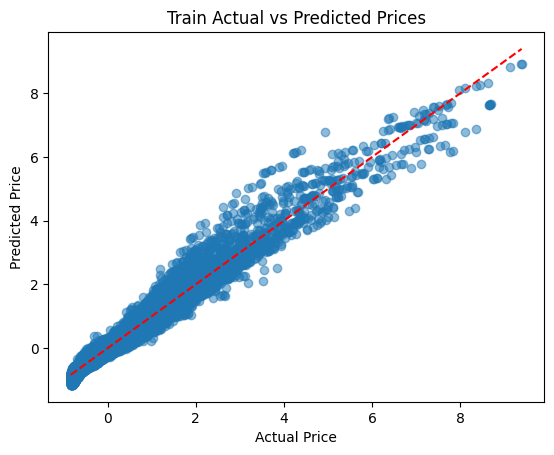

In [199]:
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Train Actual vs Predicted Prices')
plt.show()

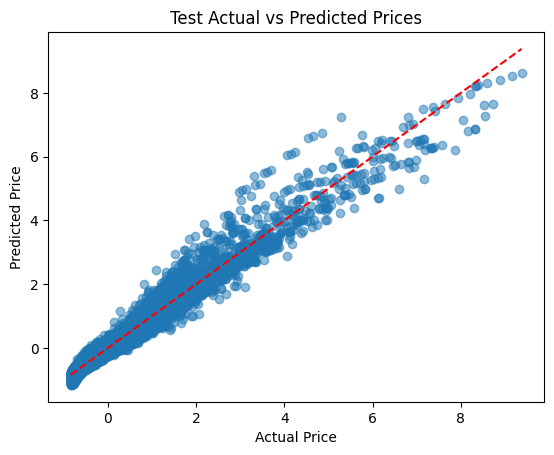

In [200]:
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Test Actual vs Predicted Prices')
plt.show()